GJ 674 has contiumn?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/'
hlsp = glob.glob('{}*.fits'.format(path))
hlsp

['/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_hst_cos_gj674_g130m_v124_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_hst_stis_gj674_g140l_v24_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_hst_stis_gj674_g140m_v24_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_hst_stis_gj674_g230l_v24_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_hst_stis_gj674_g430l_v24_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_model_apec_gj674_na_v24_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_model_dem_gj674_na_v24_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_model_euv-scaling_gj674_na_v24_component-spec.fits',
 '/media/david/2tb_ext_hd/hdd

In [3]:
sed = fits.getdata('{}hlsp_muscles_multi_multi_gj674_broadband_v24_var-res-sed.fits'.format(path),1)
wsed, fsed, esed = sed['WAVELENGTH'], sed['FLUX'], sed['ERROR']

Quesent COS spectrum

In [4]:
qw, qf, qe = np.loadtxt('/media/david/2tb_ext_hd/hddata/mega_muscles/gj674_flare/GJ674_mega_G130M_Quiesc.sav.txt', unpack=True, skiprows = 1)

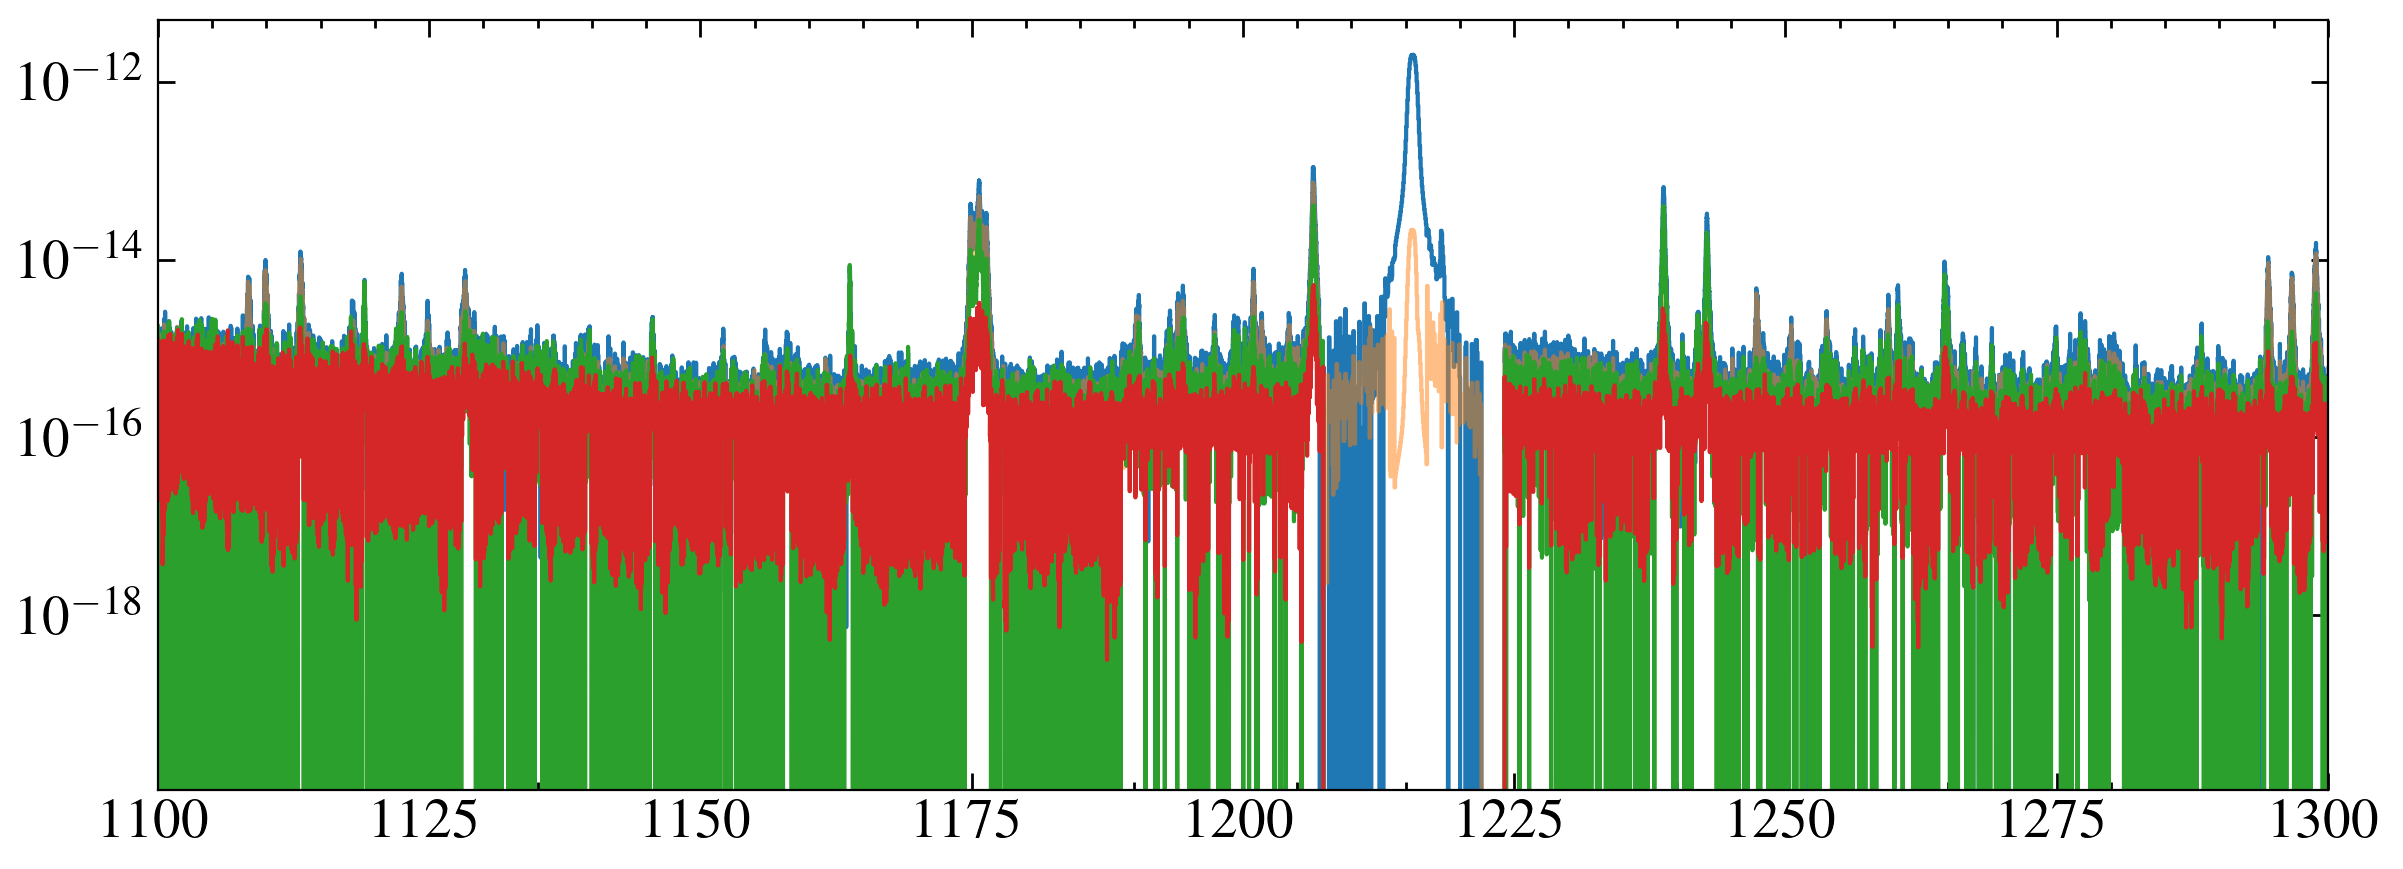

In [5]:
fig, ax = plt.subplots()

mask =( wsed > 1100 ) & (wsed < 3000)

ax.step(wsed[mask], fsed[mask], where='mid')
ax.step(wsed[mask], esed[mask], where='mid', alpha=0.5)

ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(1100, 1300)

ax.step(qw, qf, where='mid')
ax.step(qw, qe, where='mid')

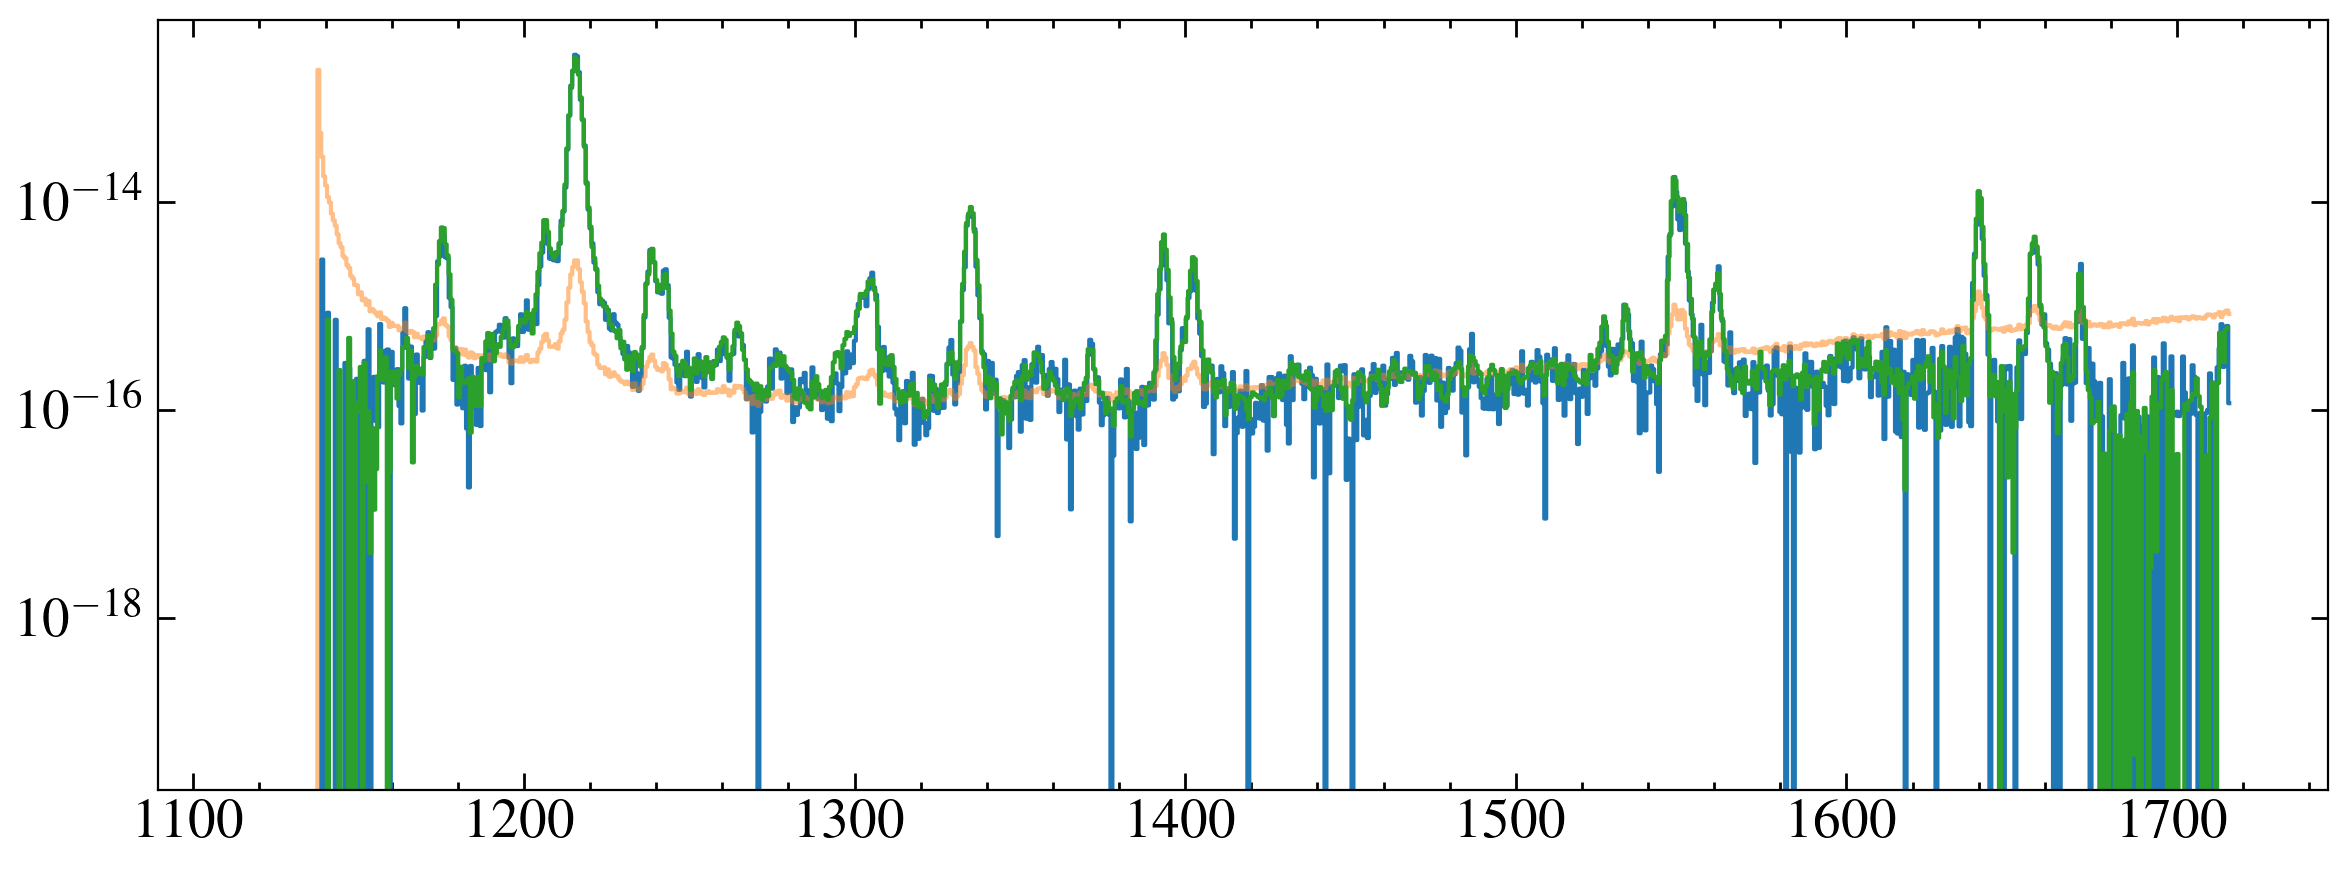

In [6]:
qs = fits.getdata('../gj_674/STIS/noflare_x1d.fits', 1)[0]
fig, ax = plt.subplots()

ax.step(qs['WAVELENGTH'], qs['FLUX'], where='mid')
ax.step(qs['WAVELENGTH'], qs['ERROR'], where='mid', alpha=0.5)

ax.set_yscale('log')

flare = fits.getdata(hlsp[1], 1)
ax.step(flare['WAVELENGTH'], flare['FLUX'], where='mid')

sw, sf, se = flare['WAVELENGTH'], flare['FLUX'], flare['ERROR']

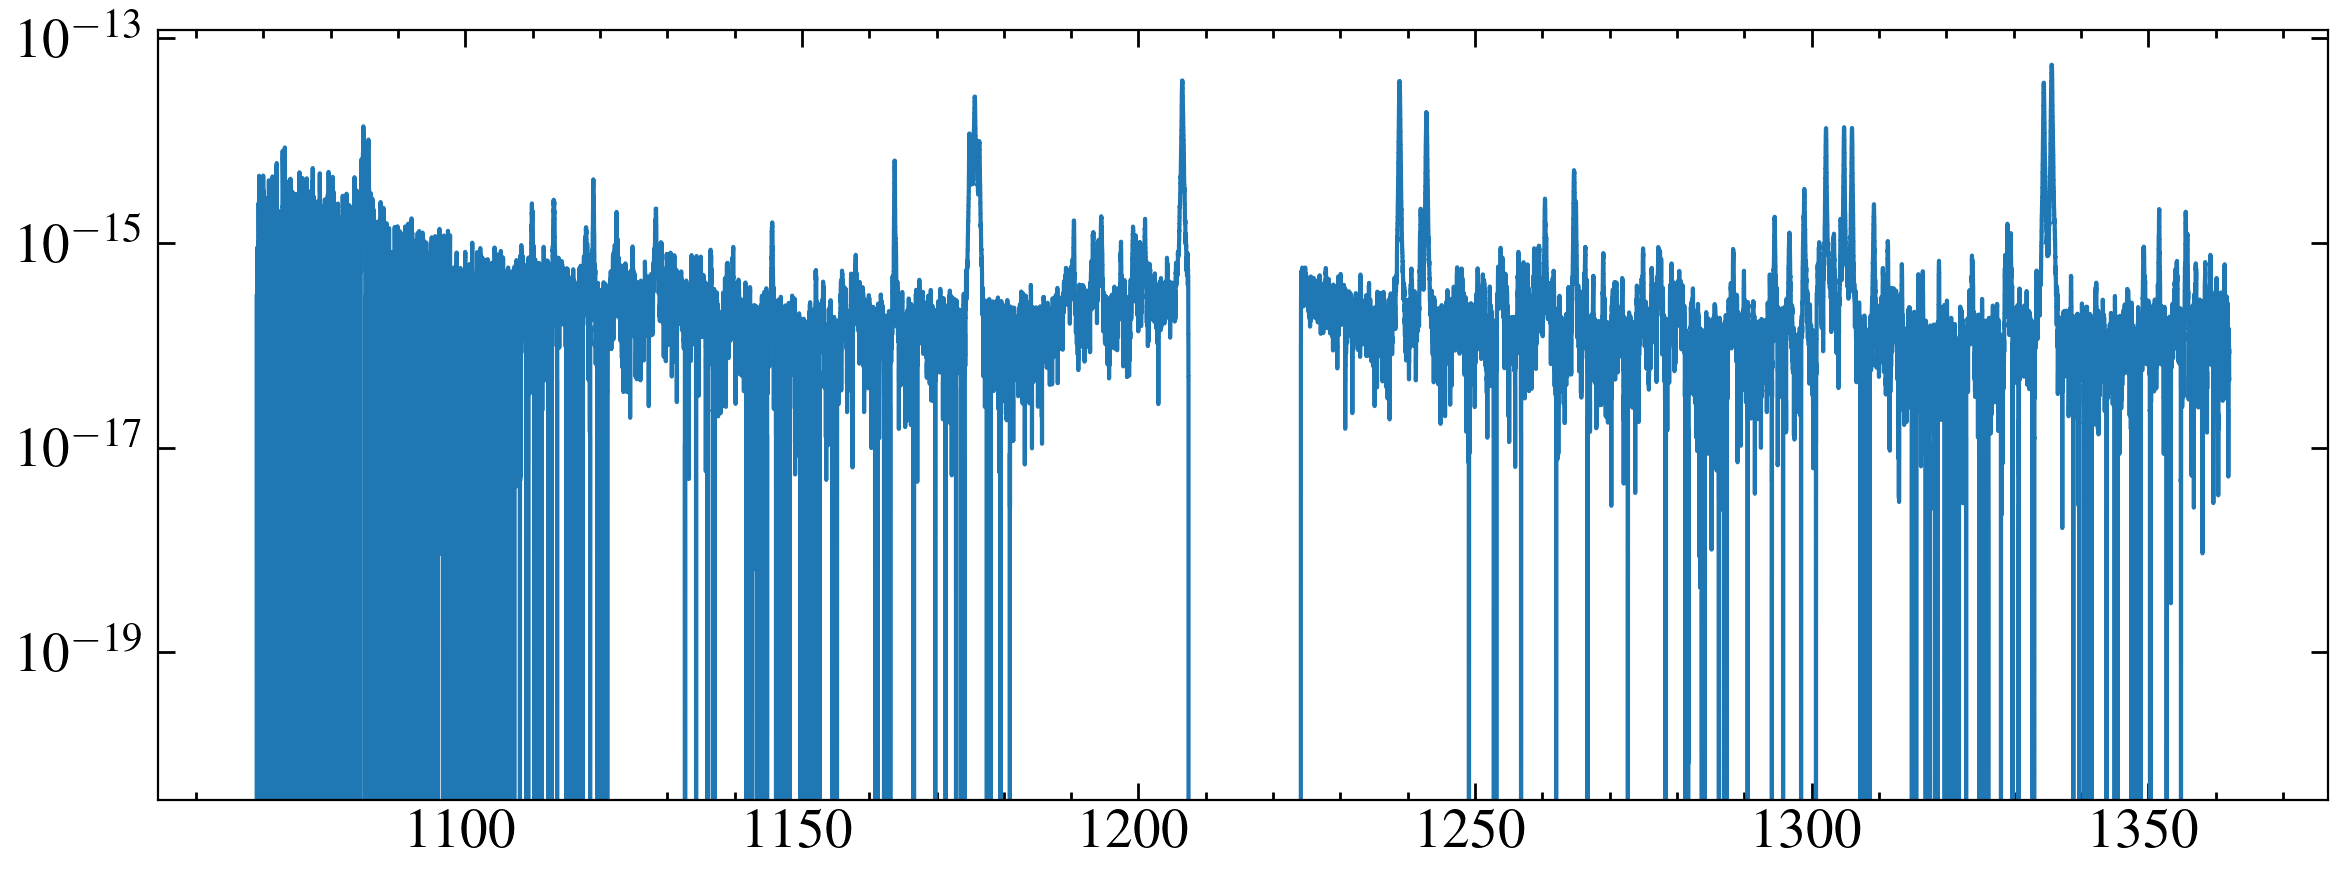

In [7]:
qfi = convolve(qf, Box1DKernel(5))
qei = convolve(qe, Box1DKernel(5))/(5**0.5)
 

fig, ax = plt.subplots()

ax.step(qw, qfi, where='mid')
# ax.step(qw, qei, where='mid')

ax.set_yscale('log')

# ax.step(sw, sf)

# ax.set_xlim(1160)

/tmp/ipykernel_212950/3966430506.py:11: RuntimeWarning: invalid value encountered in divide
  ax.step(nw, nf/ne, where='mid')


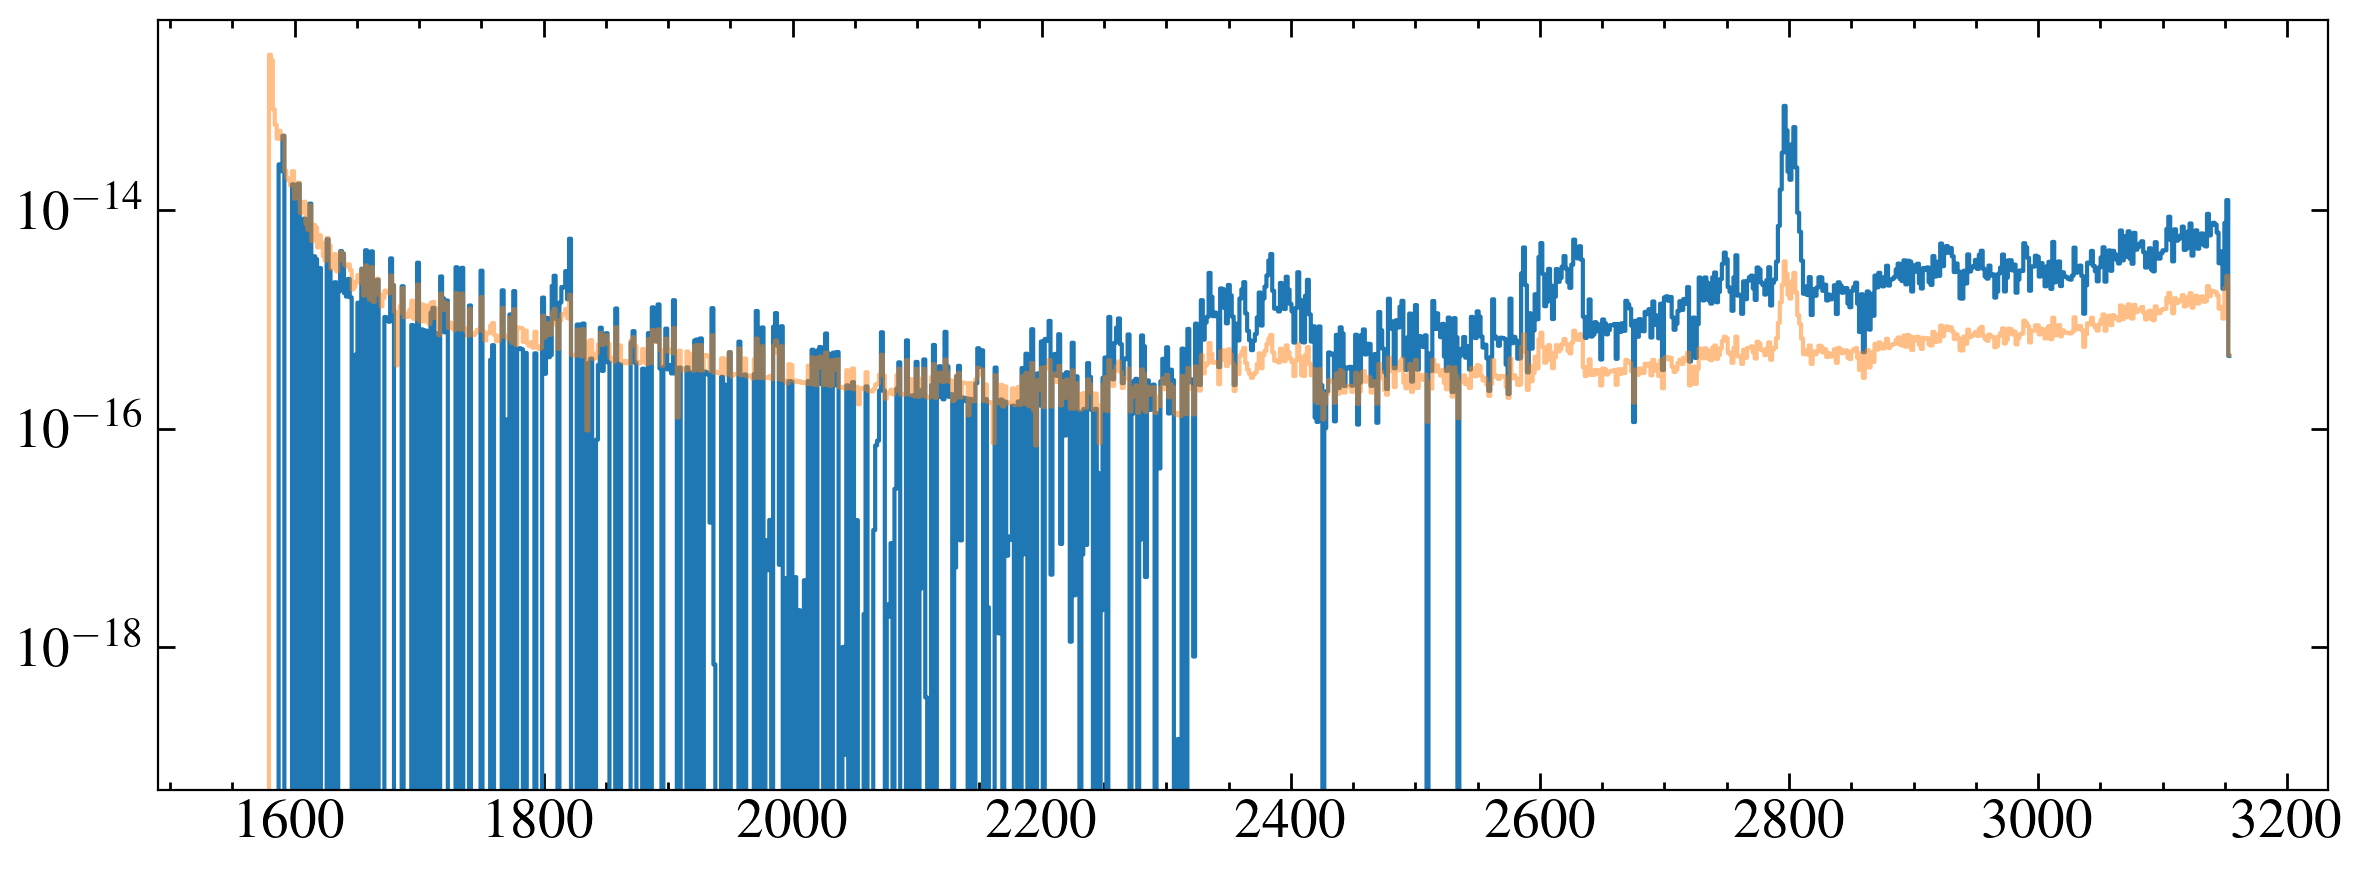

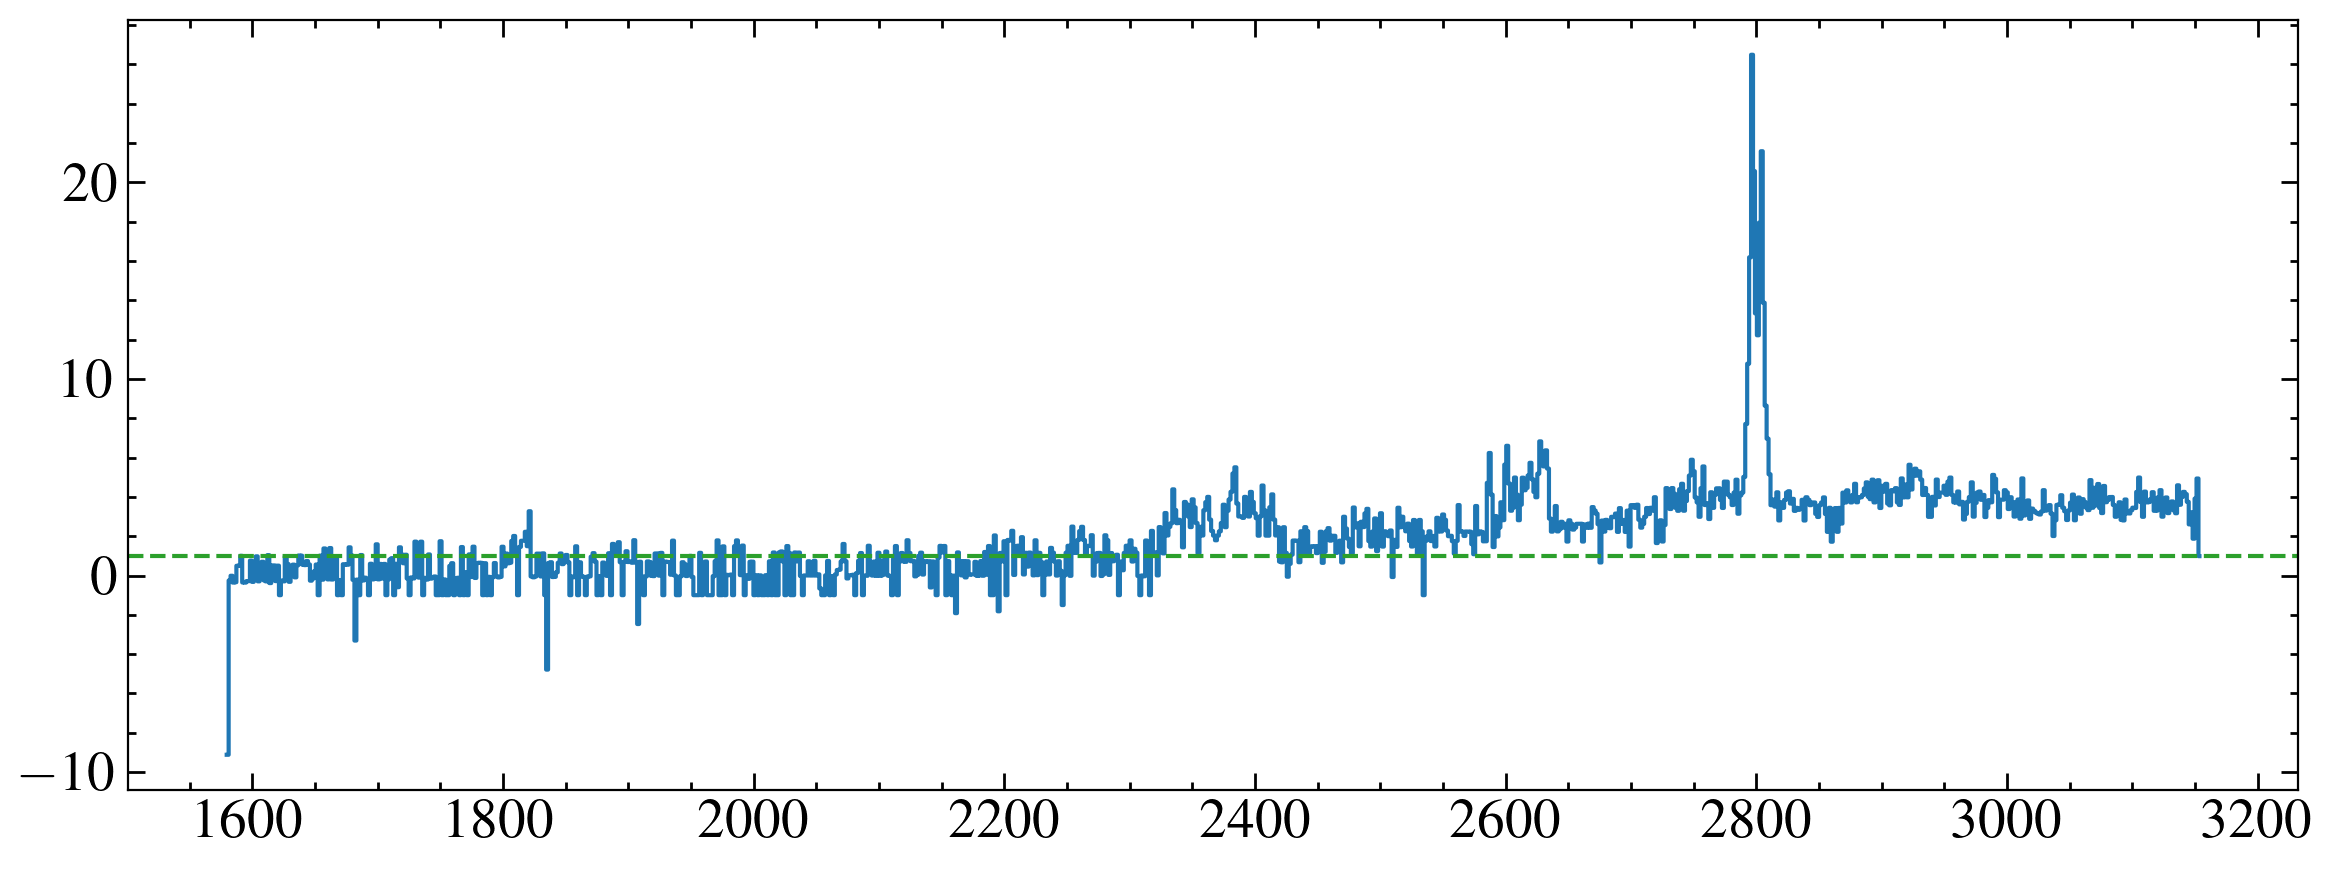

In [8]:
nspec = fits.getdata(hlsp[3])
nw, nf, ne = nspec['WAVELENGTH'], nspec['FLUX'], nspec['ERROR']
fig, ax = plt.subplots()

ax.step(nw, nf, where='mid')
ax.step(nw, ne, where='mid', alpha=0.5)

ax.set_yscale('log')

fig, ax = plt.subplots()
ax.step(nw, nf/ne, where='mid')
ax.axhline(1, ls='--', c='C2')


In [9]:
((10**14)*u.km).to(u.Rsun)

<Quantity 1.43740118e+08 solRad>

In [10]:
swiftpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/'
swift_ims = glob.glob('{}*/uvot/products/*sk.img*'.format(swiftpath))

uvm2s = []

for im in swift_ims:
    if im not in ['/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/00034290012/uvot/products/sw00034290012u_sk.img.gz', '/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/00034290020/uvot/products/sw00034290020u_sk.img.gz', '/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/00034290021/uvot/products/sw00034290021u_sk.img.gz', '/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/00034290043/uvot/products/sw00034290043u_sk.img.gz']:
        # print(im)
        filter = fits.getheader(im, 1)['FILTER'] 
        if filter == 'UVM2':
         uvm2s.append(im)
print(uvm2s)
print(len(uvm2s))

['/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/00034290002/uvot/products/sw00034290002u_sk.img.gz', '/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/00034290004/uvot/products/sw00034290004u_sk.img.gz', '/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/00034290007/uvot/products/sw00034290007u_sk.img.gz', '/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/00034290011/uvot/products/sw00034290011u_sk.img.gz', '/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/00034290015/uvot/products/sw00034290015u_sk.img.gz', '/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/00034290019/uvot/products/sw00034290019u_sk.img.gz', '/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/00034290023/uvot/products/sw00034290023u_sk.img.gz', '/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/00034290028/uvot/products/sw00034290028u_sk.img.gz', '/media/david/2tb_ext_hd/hddata/mega_muscles/swift/gj674/00034290034/uvot/products/sw00034290034u_sk.img.gz', '/media/d

Looks like 2300 A for the NUV spectrum. Use just the STIS FUV spectrum to avoid complications?

In [11]:
phx = fits.getdata(hlsp[9], 1)
pwi, pfi = phx['WAVELENGTH'], phx['FLUX']*fits.getheader(hlsp[9], 0)['NORMFAC']

In [12]:
pwmask = (pwi > 1000) & (pwi < 3500) 

pw, pf = pwi[pwmask], pfi[pwmask]

respix = (pw[-1] - pw[0])/len(pw)
# print(respix)
FWHM = 1.6/respix #for 3A res
sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))


pf = convolve(pf, Gaussian1DKernel(sigma))

In [13]:
eps_eri = fits.getdata('/media/david/2tb_ext_hd/hddata/mega_muscles/muscles_hlsp/v-eps-eri/hlsp_muscles_multi_multi_v-eps-eri_broadband_v22_var-res-sed.fits', 1)

ew, ef = eps_eri['WAVELENGTH'], eps_eri['FLUX']

In [14]:
soldat = Table.read('../../../hwo/Solar_1au_sed.csv')
solw, solf = soldat['WAVELENGTH'], soldat['FLUX']

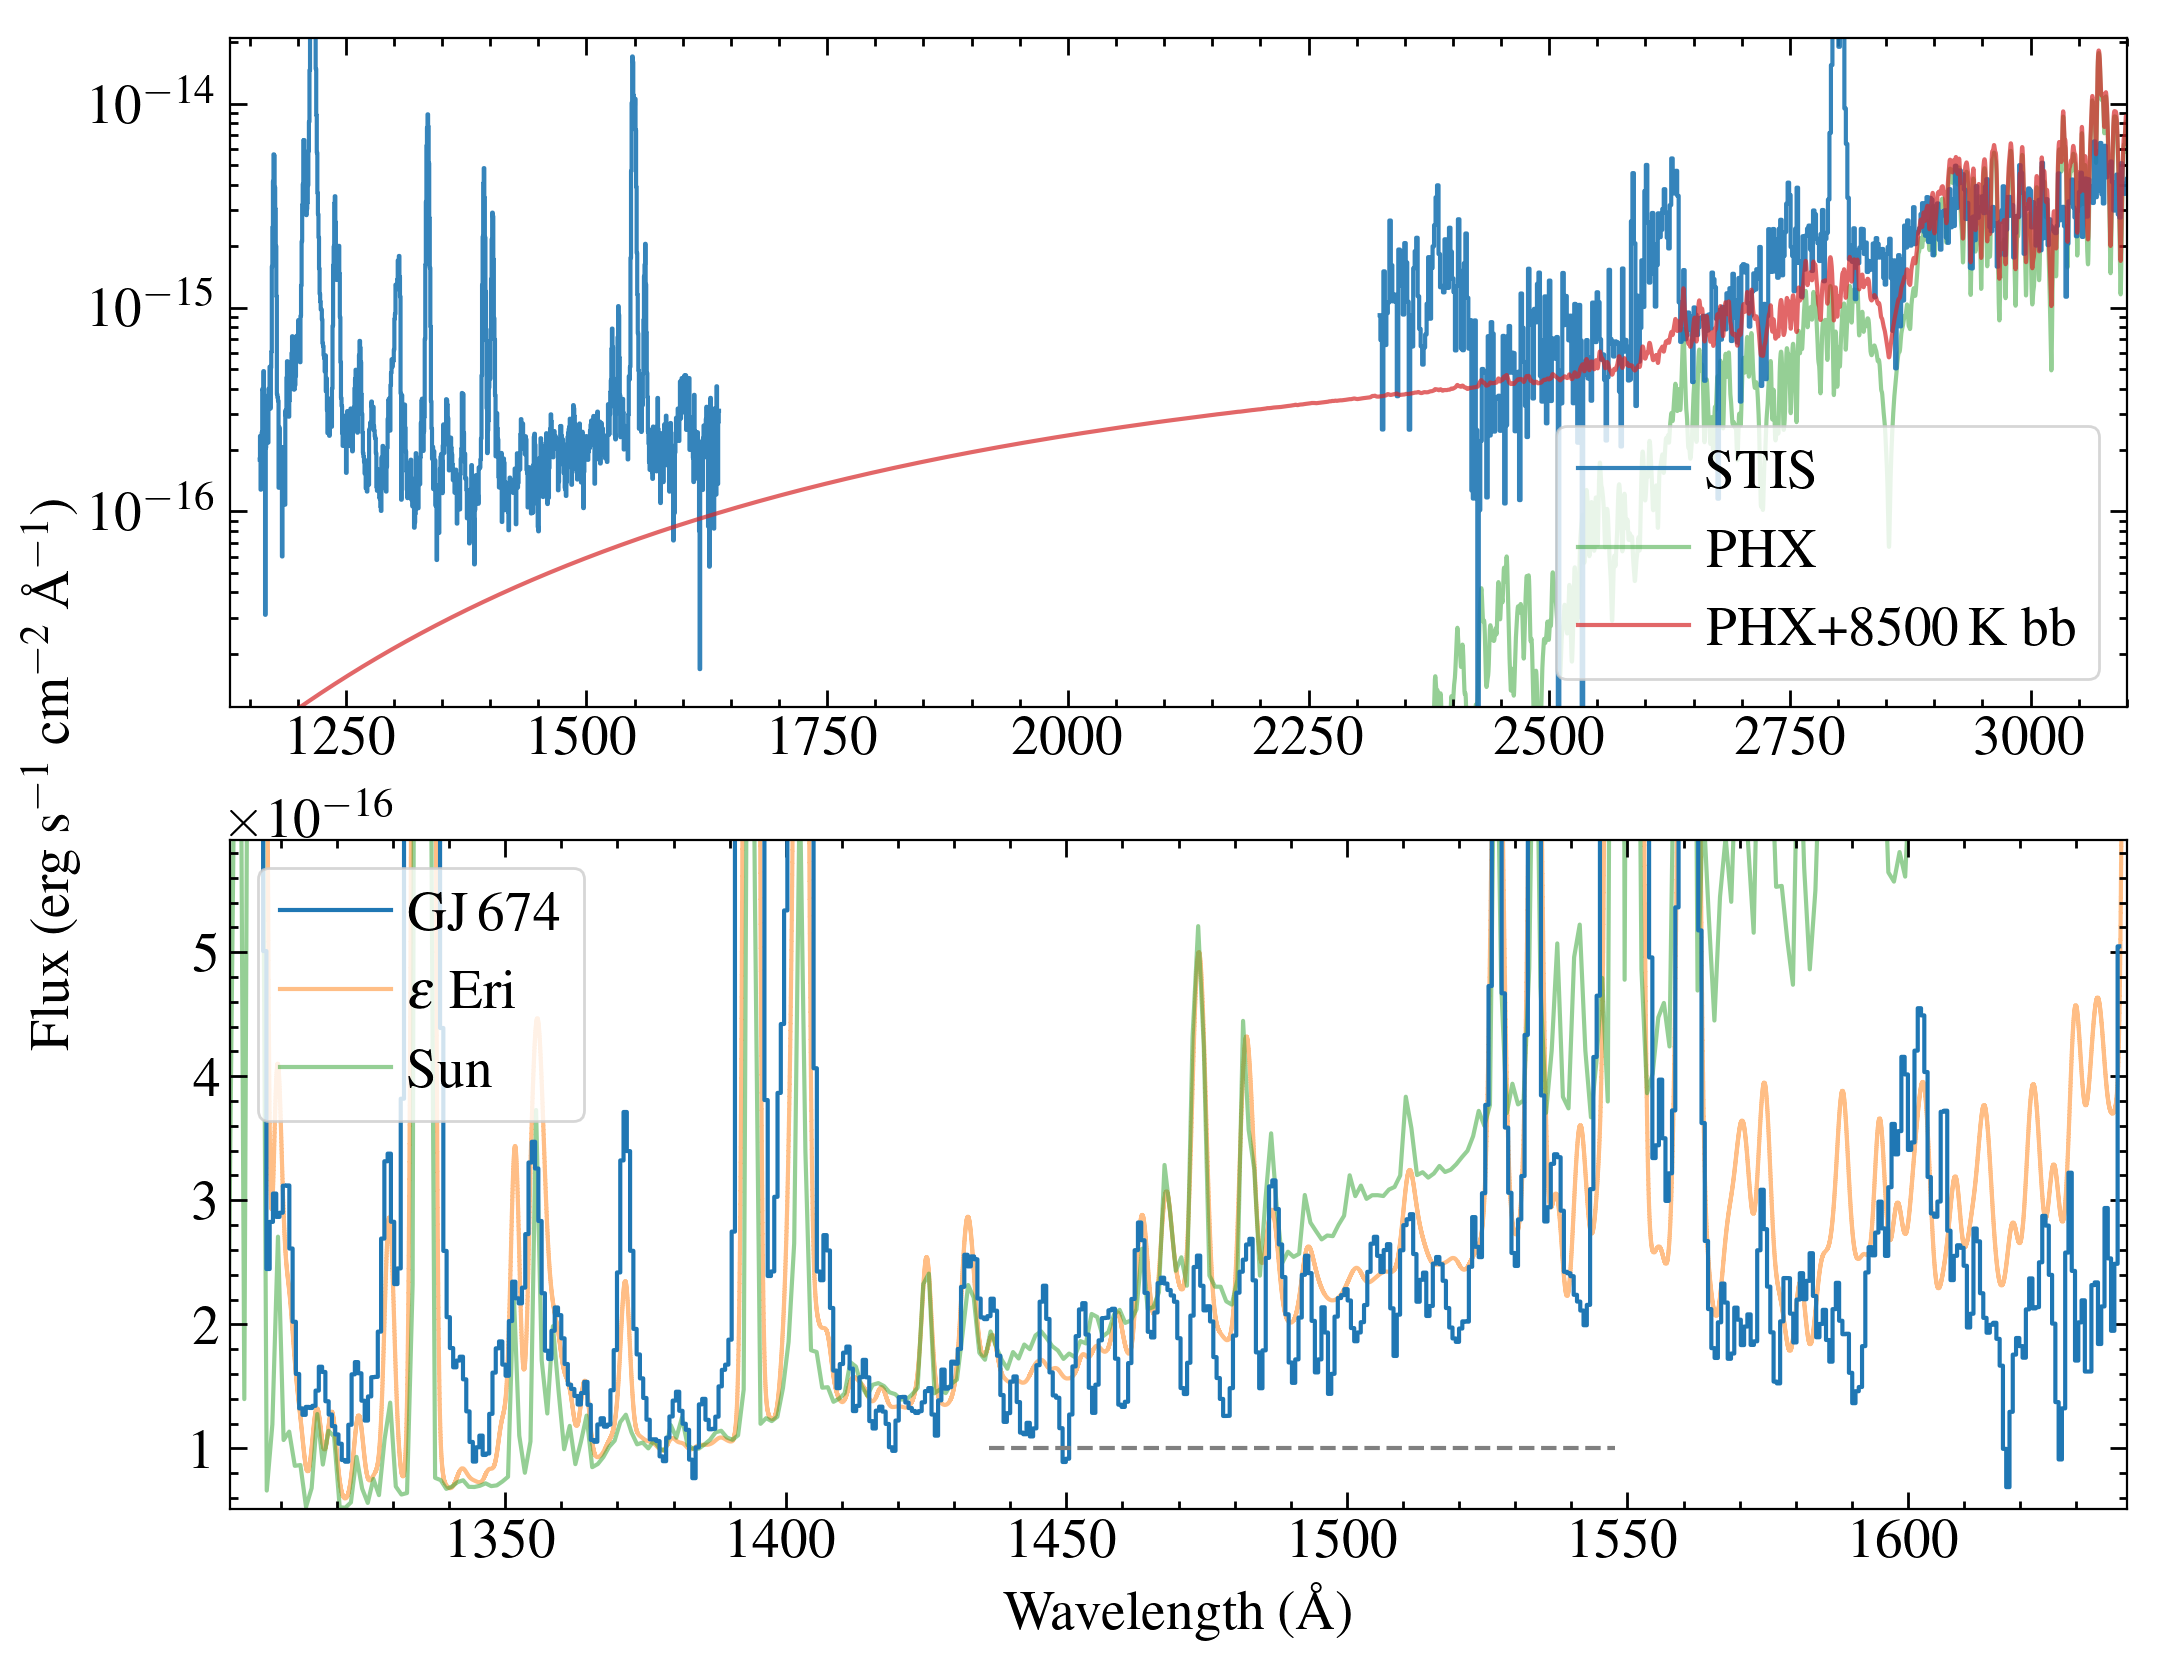

In [15]:
nmask = (nw > 2323)
smask = (sw > 1160) & (sw < 1638)

fig, axes = plt.subplots(figsize=(12, 9), nrows=2)

ax = axes[0]

ax.step(nw[nmask], nf[nmask], where='mid', label='STIS', c='C0', alpha=0.9)
ax.step(sw[smask], sf[smask], where='mid', c='C0', alpha=0.9)
# ax.step(sw[smask], sf[smask], where='mid', label='STIS G140L')
# ax.step(sw, sf)

ax.plot(pw, pf, zorder=-1, label = 'PHX', c='C2', alpha=0.5)

pfs = interp1d(pw, pf, fill_value='extrapolate')(nw)

# ax.step(nw[nmask], nf[nmask]-pfs[nmask], where='mid')


bb_mod = models.BlackBody(temperature=8500*u.K, scale=3e-23*u.erg/u.s/u.cm**2/u.AA/u.sr, fixed=dict(temperature=True))
# modw = np.linspace(1000, 3200, 1000)

# ax.plot(pw, bb_mod(pw), ls='--')
ax.plot(pw, bb_mod(pw).value+pf, label='PHX+8500\,K bb', c='C3', alpha=0.7) 
ax.legend(frameon=True, loc=4)


ax.set_yscale('log')
ax.set_ylim(1.1e-17, 2.1e-14)
ax.set_xlim(1130, 3100)
# ax.se


emask = (ew > 1000) & (ew < 2000)
sfi = convolve(sf, Box1DKernel(2))

axes[1].step(sw[smask], sfi[smask], where='mid', label='GJ\,674')
# axes[1].errorbar(sw[smask], sf[smask], yerr=se[smask], errorevery=10, drawstyle='steps-mid', label='GJ\,674')
# sei = convolve(se, Box1DKernel())
# axes[1].step(sw[smask], sei[smask], where='mid', alpha=0.5)


efi = convolve(ef, Gaussian1DKernel(80))
axes[1].step(ew[emask], efi[emask]*0.03, where='mid', label=r'$\epsilon$ Eri', zorder=-1, alpha=0.5)

solmask = (solw > 1000) & (solf < 2000)

axes[1].plot(solw[solmask], solf[solmask]*4e-14, zorder=-1, alpha=0.5, label='Sun')

axes[1].legend(frameon=True)
axes[1].set_xlim(1301, 1639)
axes[1].set_ylim(0.51e-16, 0.59e-15)

axes[1].axhline(y=1e-16, xmin=0.4,xmax=0.73, ls='--', c='0.5')

bigax = fig.add_subplot(111, frame_on=False)
bigax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
bigax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', labelpad=25)
bigax.set_xlabel('Wavelength (\AA)')



fig.tight_layout()
fig.subplots_adjust(hspace=0.2)

fig.savefig('plots/gj674_cont.pdf')

Look at TESS data

In [16]:
# import lightkurve as lk


In [17]:
# search_result = lk.search_lightcurve('GJ 674')
# search_result

In [18]:
# lc120s = []
# for i, sr in enumerate(search_result):
#     if sr.exptime[0].value == 120 and sr.author[0] == 'SPOC':
#         print(i)
#         lc120s.append(i)
# #         print(sr./#[0])
#         lc = sr.download(download_dir='mastDownload/')
#         lc = lc.normalize()
#         lc.plot()
# print(lc120s)

Check - does the flare make a difference?

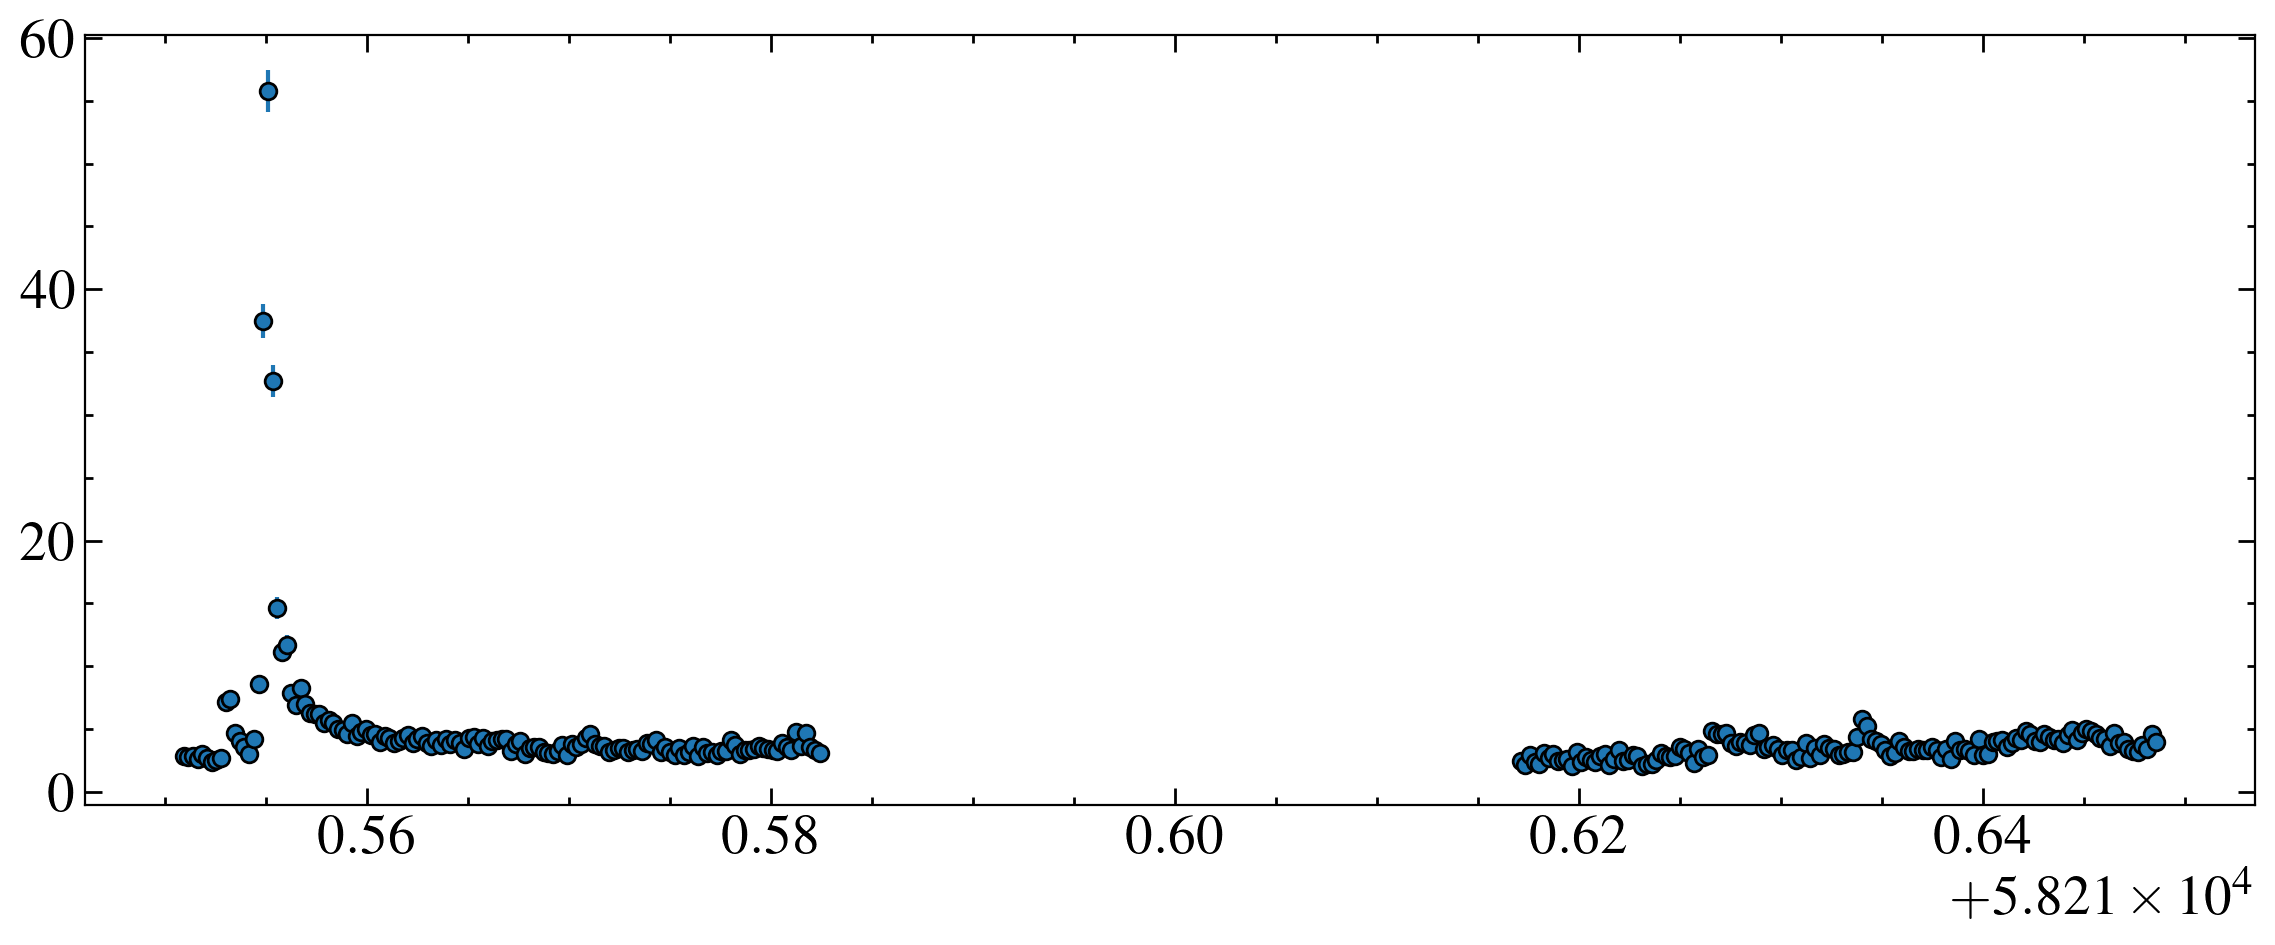

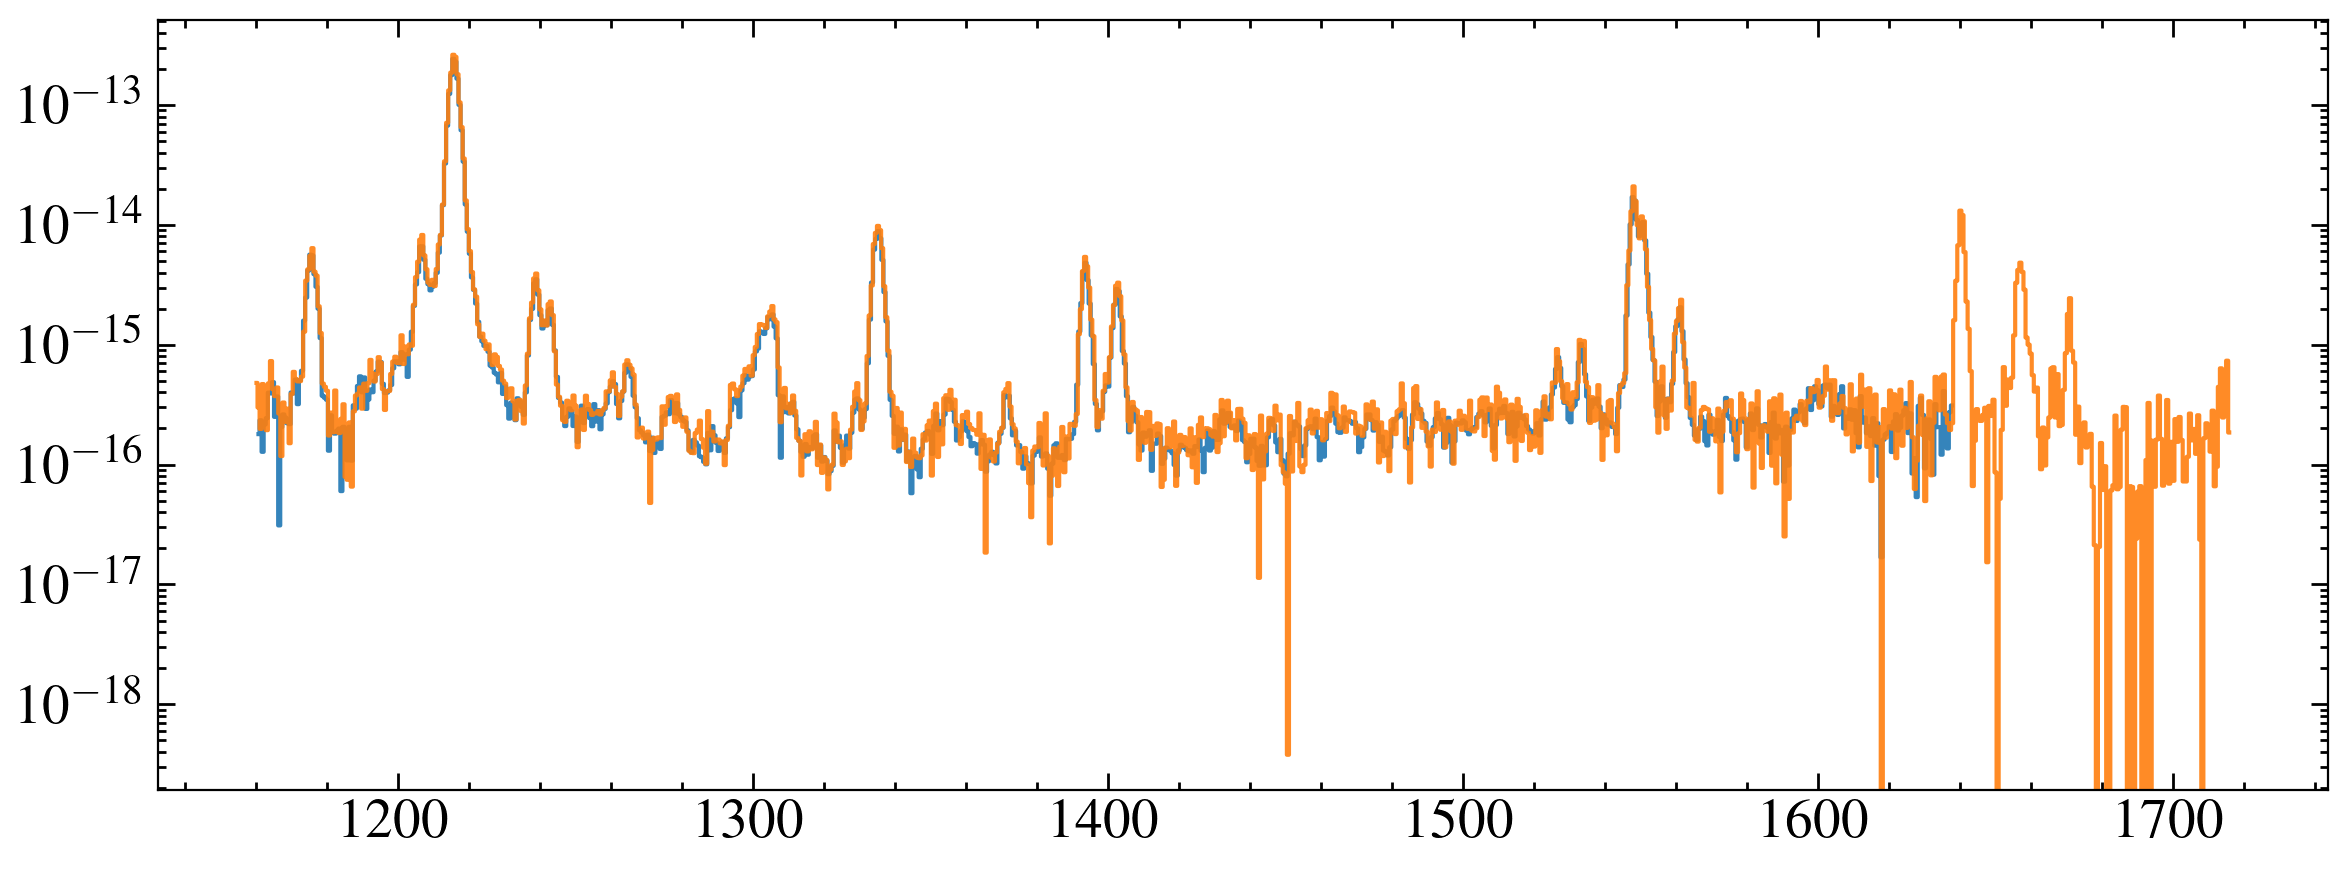

In [35]:
flarepath = '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/'
flare_roots  = ['ODLM21050', 'ODLM21050']

lc = Table.read('{}../../light_curves/GJ674_g140l_20s_lc.ecsv'.format(flarepath))

# for root in 
fig, ax = plt.subplots()
ax.errorbar(lc['MJD'], lc['COUNTS'], yerr=lc['COUNTS_ERROR'], marker='o', markeredgecolor='k', ls='none')
plt.show()

fs = []

# fig, ax = plt.subplots()
for i, root in enumerate(flare_roots):
    x = '{}{}_20s_x1d.fits'.format(flarepath, root.lower())
    hdul = fits.open(x)
    for j, ext in enumerate(hdul[1::]): #spectra in every extension after the first
        data = ext.data[0]
        mask =data['WAVELENGTH'] > 1160
        # ax.step(data['WAVELENGTH'][mask], data['FLUX'][mask], where='mid', alpha=0.5)
        if i == 0:
            if j > 40:
                fs.append(data['FLUX'])
        else:
                fs.append(data['FLUX'])
# # plt.show()

outflare = np.mean(fs, axis =0)
fig, ax = plt.subplots()
ax.step(sw[smask], sf[smask], where='mid', c='C0', alpha=0.9)
ax.step(data['WAVELENGTH'][mask], outflare[mask], where='mid', alpha=0.9, c='C1')

ax.set_yscale('log')

plt.show()

Nope. Good.